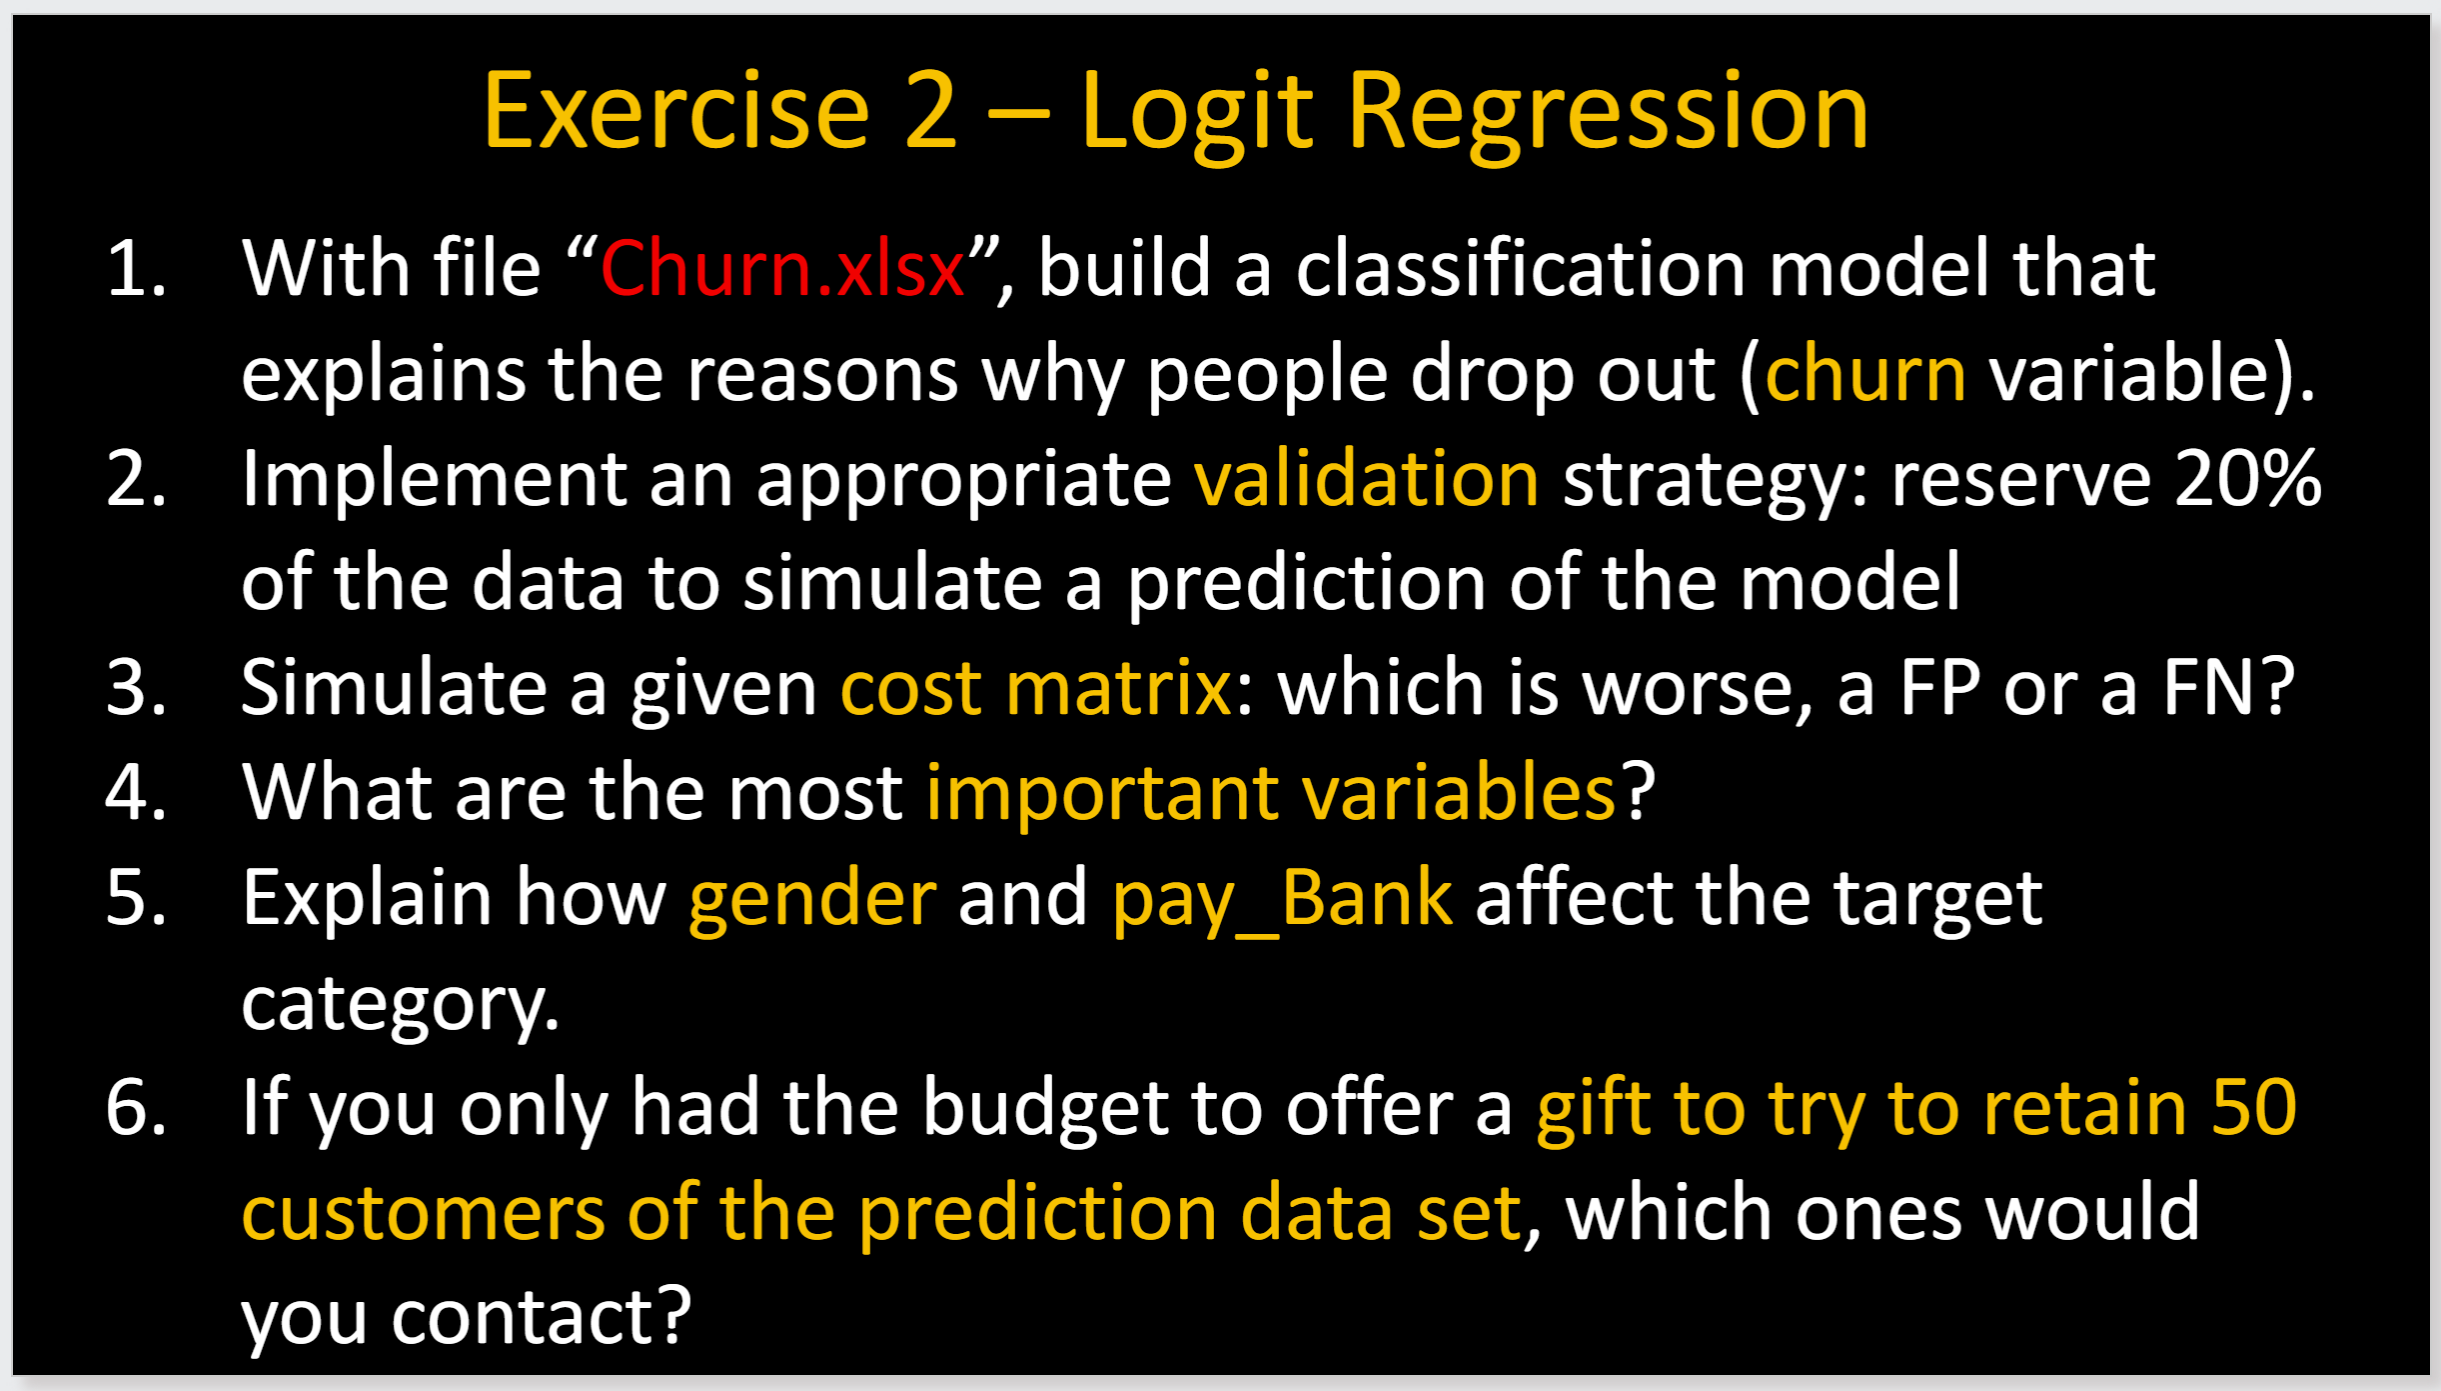

In [2]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import pylab as pl
import numpy as np

import warnings                              # Disable some warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
df = pd.read_excel('Churn.xlsx')
df.head()

,id,longdist,internat,local,int_disc,billtype,age,gender,marital,children,est_inco,car,pay_Bank,pay_CreditCard,pay_Cash,churn
0,1,27.09360,0.0,39.7357,0,1,35,1,1,0,77680.0,0,0,1,0,0
1,2,10.04270,0.0,46.3118,0,0,53,0,0,1,37111.5,1,1,0,0,0
2,3,23.76050,0.0,68.3512,1,1,65,1,1,1,37079.4,0,1,0,0,0
3,4,9.39559,0.0,13.9003,0,0,90,0,0,2,81997.0,0,0,0,1,0
4,5,14.15420,0.0,108.4330,1,0,39,1,0,0,16829.6,0,1,0,0,0


In [4]:
target = 'churn'
df.describe()

,id,longdist,internat,local,int_disc,billtype,age,gender,marital,children,est_inco,car,pay_Bank,pay_CreditCard,pay_Cash,churn
count,4431.000000,4431.000000,4431.000000,4431.000000,4431.000000,4431.000000,4431.000000,4431.000000,4431.000000,4431.000000,4431.000000,4431.000000,4431.000000,4431.000000,4431.000000,4431.000000
mean,2216.000000,13.637284,0.836382,51.364432,0.310765,0.506432,57.562627,0.506432,0.593094,0.989167,50290.691485,0.312119,0.201083,0.578199,0.220718,0.436696
std,1279.263851,9.392118,2.236353,54.670249,0.462859,0.500015,22.837498,0.500015,0.491312,0.824495,28438.785301,0.463410,0.400855,0.493903,0.414777,0.496032
min,1.000000,0.000000,0.000000,0.049147,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,110.284000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1108.500000,5.173330,0.000000,13.460000,0.000000,0.000000,38.000000,0.000000,0.000000,0.000000,25445.600000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2216.000000,13.683000,0.000000,35.014400,0.000000,1.000000,58.000000,1.000000,1.000000,1.000000,50290.700000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,3323.500000,22.078400,0.000000,71.661400,1.000000,1.000000,77.000000,1.000000,1.000000,2.000000,75004.500000,1.000000,0.000000,1.000000,0.000000,1.000000
max,4431.000000,29.982000,9.950900,450.624000,1.000000,1.000000,97.000000,1.000000,1.000000,2.000000,99832.900000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# Split the model 90 - 10 for future testing

df_model, df_reserved = train_test_split(df, test_size=0.1, random_state=42)
print ("Sample size dataset reserved for prediction: ", df_reserved.shape[0], "records")

Sample size dataset reserved for prediction:  444 records


In [6]:
Y = df_model[target]

# Cross validation
X_train, X_test, Y_train, Y_test = train_test_split(df_model, Y, test_size = 0.2)
print(f'Train sample size: {X_train.shape}')
print(f'Test sample size: {X_test.shape}')

Train sample size: (3189, 16)
Test sample size: (798, 16)


In [7]:
# Stepwise function
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.05, 
                       threshold_out = 0.1, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [8]:
irrelevant_columns = ['id', target]

X_train2 = X_train.drop(columns = irrelevant_columns)

for field in X_train2:
    if X_train2[field].isnull().any():
        X_train2 = X_train2.drop(labels = [field], axis = 1)

X_train2

,longdist,internat,local,int_disc,billtype,age,gender,marital,children,est_inco,car,pay_Bank,pay_CreditCard,pay_Cash
311,24.14750,3.109910,7.86899,0,0,30,1,1,1,69341.7,0,0,1,0
3327,26.95060,0.000000,29.96750,0,0,55,1,0,0,54844.2,1,0,1,0
3029,27.04450,0.905168,14.63830,1,0,91,0,1,0,17527.3,0,1,0,0
512,20.87980,4.498280,66.59960,1,0,54,1,1,0,69641.6,0,0,0,1
379,2.47651,0.000000,21.58350,1,0,83,0,0,0,52774.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2065,18.85080,0.000000,31.78860,1,0,73,1,1,2,35976.5,1,1,0,0
3666,22.72620,0.000000,10.91340,0,1,86,1,1,2,36090.7,0,0,0,1
4063,0.00000,0.000000,1.03882,0,0,82,1,0,1,95877.7,0,1,0,0
470,7.25034,0.000000,10.98540,0,0,30,1,1,2,45171.2,0,0,1,0


In [9]:
result = stepwise_selection(X_train2, Y_train)
print('Resulting features')
print(result)

Optimization terminated successfully.
         Current function value: 0.685534
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684259
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685467
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685446
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682145
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685533
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.649795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685532
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.668228
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685433
  

In [10]:
X_train_stepwise = X_train2

for item in X_train2.columns:
    if item not in result:
        X_train_stepwise = X_train_stepwise.drop(labels = [item], axis = 1)

X_train_stepwise

,longdist,internat,local,age,gender,est_inco
311,24.14750,3.109910,7.86899,30,1,69341.7
3327,26.95060,0.000000,29.96750,55,1,54844.2
3029,27.04450,0.905168,14.63830,91,0,17527.3
512,20.87980,4.498280,66.59960,54,1,69641.6
379,2.47651,0.000000,21.58350,83,0,52774.0
...,...,...,...,...,...,...
2065,18.85080,0.000000,31.78860,73,1,35976.5
3666,22.72620,0.000000,10.91340,86,1,36090.7
4063,0.00000,0.000000,1.03882,82,1,95877.7
470,7.25034,0.000000,10.98540,30,1,45171.2


In [11]:
X_test_stepwise = X_test

for item in X_test.columns:
    if item not in result:
        X_test_stepwise = X_test_stepwise.drop(labels = [item], axis = 1)

X_test_stepwise

,longdist,internat,local,age,gender,est_inco
3808,21.45060,0.00000,55.46630,88,1,94665.2
944,0.00000,0.00000,2.77568,50,0,33043.1
942,9.36452,0.00000,15.75630,19,0,22567.9
2243,16.46070,0.00000,57.65690,93,1,74912.1
3881,28.79600,4.91752,89.46480,67,0,81360.6
...,...,...,...,...,...,...
750,24.75250,1.48495,62.62830,45,1,50290.7
1942,3.89387,0.00000,67.73110,19,0,71861.9
161,20.70020,0.00000,20.05580,93,0,25949.0
1710,19.51640,0.00000,86.45360,82,1,17491.4


<Axes: >

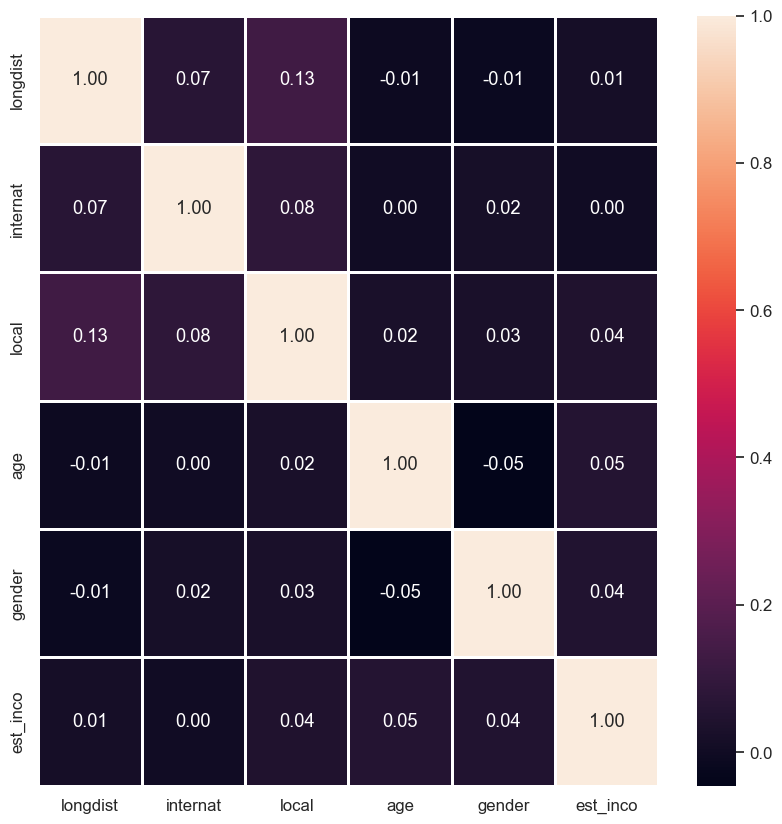

In [12]:
# and heatmap to show correlation between explanatory variables
from matplotlib import pyplot as plt        
import seaborn as sns                       

sns.set(font_scale=1.1)
fig, ax = plt.subplots(figsize=(10,10))         
sns.heatmap(X_train_stepwise.corr(), annot=True, fmt=".2f", linewidths=1, ax=ax)

In [15]:
X_train_stepwise = sm.add_constant(X_train_stepwise)

# Stats model
import statsmodels.api as sm
logit_model = sm.Logit(Y_train, X_train_stepwise)
result = logit_model.fit_regularized()
print(result.summary2())

params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['Lower', 'Upper', 'Odds Ratio']
print ("\nexp(B) & confidence intervals: ")
print (np.exp(conf))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.48229355866077966
            Iterations: 26
            Function evaluations: 42
            Gradient evaluations: 26
                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: churn            Pseudo R-squared: 0.296      
Date:               2025-02-05 11:34 AIC:              3090.0683  
No. Observations:   3189             BIC:              3132.5406  
Df Model:           6                Log-Likelihood:   -1538.0    
Df Residuals:       3182             LL-Null:          -2186.2    
Converged:          1.0000           LLR p-value:      6.9558e-277
No. Iterations:     26.0000          Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
const   

C:\Users\SLO\AppData\Roaming\Python\Python38\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\SLO\AppData\Roaming\Python\Python38\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


In [16]:
cutoffs = [0.1, 0.5, 1]

for cutoff in cutoffs:
    train_preds = result.predict(X_train_stepwise)
    train_preds_binary = (train_preds > cutoff).astype(int)
    train_conf_matrix = confusion_matrix(Y_train, train_preds_binary)

    train_conf_matrix_percentage = train_conf_matrix.astype('float') / train_conf_matrix.sum() * 100
    train_conf_matrix_percentage = np.round(train_conf_matrix_percentage, 2)

    print(f'Train Dataset Confustion Matrix (Cutoff: {cutoff})')
    print(train_conf_matrix_percentage)

Train Dataset Confustion Matrix (Cutoff: 0.1)
[[15.68 40.48]
 [ 0.88 42.96]]
Train Dataset Confustion Matrix (Cutoff: 0.5)
[[43.59 12.57]
 [11.73 32.11]]
Train Dataset Confustion Matrix (Cutoff: 1)
[[56.16  0.  ]
 [43.84  0.  ]]


In [17]:
cutoffs = [0.1, 0.5, 1]

X_test_stepwise = sm.add_constant(X_test_stepwise)

for cutoff in cutoffs:
    test_preds = result.predict(X_test_stepwise)
    test_preds_binary = (test_preds > cutoff).astype(int)
    test_conf_matrix = confusion_matrix(Y_test, test_preds_binary)

    test_conf_matrix_percentage = test_conf_matrix.astype('float') / test_conf_matrix.sum() * 100
    test_conf_matrix_percentage = np.round(test_conf_matrix_percentage, 2)

    print(f'Test Dataset Confustion Matrix (Cutoff: {cutoff})')
    print(test_conf_matrix_percentage)

Test Dataset Confustion Matrix (Cutoff: 0.1)
[[14.91 42.48]
 [ 0.88 41.73]]
Test Dataset Confustion Matrix (Cutoff: 0.5)
[[43.61 13.78]
 [11.4  31.2 ]]
Test Dataset Confustion Matrix (Cutoff: 1)
[[57.39  0.  ]
 [42.61  0.  ]]


In [18]:
#defines the function to draw the curve with three parameters
def ROCCurve (df, target, txtdataset): #df is the data set, targ is 
    result = sm.Logit(target, df).fit()
    df['pred'] = result.predict(df)

    # AUC
    result = sm.Logit(target, df).fit()
    X_train_stepwise['pred'] = result.predict(df)
    fpr, tpr, thresholds =roc_curve(target, df['pred'])
    roc_auc = auc(fpr, tpr)
    print("Area under the ROC curve : %f" % roc_auc)
    
    # Draws the roc curve
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots() 
    title='ROC curve for ' + txtdataset + " dataset"
    ax.set_title(title)
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.plot(fpr, tpr) #False Positive Rate(x axis) vs. True Positive Rate (y axis)
    ax.plot([0, 1], [0, 1], color="green")
    
    # Optimal cut-off
    i = np.arange(len(tpr)) # index for df
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'cut-off' : pd.Series(thresholds, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    print("Optimal cut-off for accuracy : " , list(roc_t['cut-off']))

Optimization terminated successfully.
         Current function value: 0.482294
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481661
         Iterations 7
Area under the ROC curve : 0.845004
Optimal cut-off for accuracy :  [0.4841684295699068]


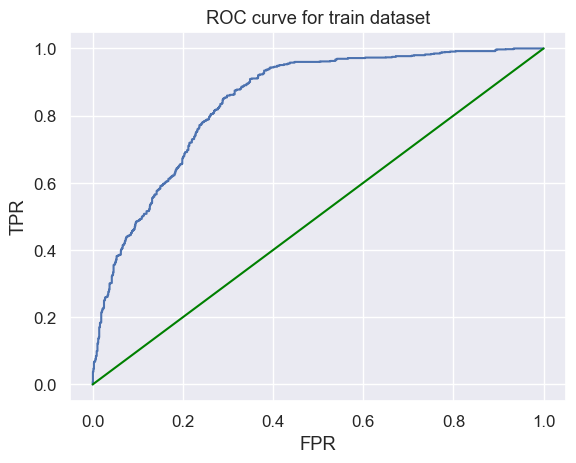

In [19]:
ROCCurve (X_train_stepwise, Y_train, "train")

Optimization terminated successfully.
         Current function value: 0.499094
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498829
         Iterations 7
Area under the ROC curve : 0.835179
Optimal cut-off for accuracy :  [0.43894404266114495]


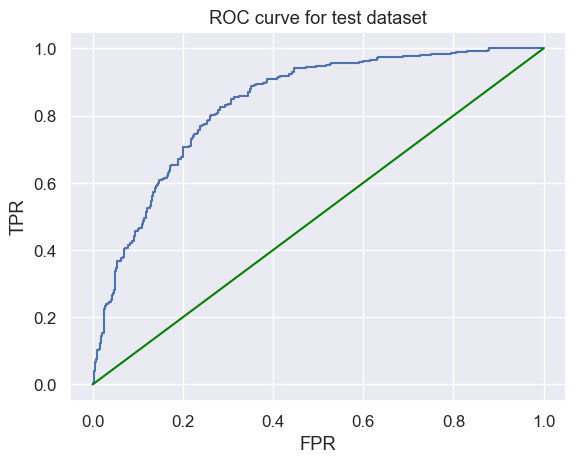

In [20]:
ROCCurve (X_test_stepwise, Y_test, "test")